In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cwd = "/content/drive/MyDrive/6.7900 Final Project"
os.chdir(cwd)
# !pwd
# os.chdir("/content")
# !pwd

In [3]:
# load in metadata
metadata_path = f'{cwd}/ArtBench-10.csv'

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam

import torchvision
from torchvision import datasets, transforms

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np
import math

from IPython.display import Image, display

In [5]:
mini_dataset_path = f'{cwd}/miniroot'
dataset_path = 'artbench-10-imagefolder-split'
dataset_32_path = 'artbench-10-imagefolder-split-32'
dataset_32_path_test = 'artbench-10-imagefolder-split-32-test'

In [6]:
BATCH_SIZE = 32
NUM_WORKERS = 2

In [7]:
# !tar -xvf '/content/drive/MyDrive/6.7900 Final Project/artbench-10-python.tar.gz'

In [8]:
from torchvision.datasets import CIFAR10

class ArtBench10(CIFAR10):

    base_folder = "artbench-10-batches-py"
    url = "https://artbench.eecs.berkeley.edu/files/artbench-10-python.tar.gz"
    filename = "artbench-10-python.tar.gz"
    tgz_md5 = "9df1e998ee026aae36ec60ca7b44960e"
    train_list = [
        ["data_batch_1", "c2e02a78dcea81fe6fead5f1540e542f"],
        ["data_batch_2", "1102a4dcf41d4dd63e20c10691193448"],
        ["data_batch_3", "177fc43579af15ecc80eb506953ec26f"],
        ["data_batch_4", "566b2a02ccfbafa026fbb2bcec856ff6"],
        ["data_batch_5", "faa6a572469542010a1c8a2a9a7bf436"],
    ]

    test_list = [
        ["test_batch", "fa44530c8b8158467e00899609c19e52"],
    ]
    meta = {
        "filename": "meta",
        "key": "styles",
        "md5": "5bdcafa7398aa6b75d569baaec5cd4aa",
    }

In [9]:
# play around with other transformations later
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

train_transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    # transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

test_transform_32 = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [10]:
# train_dataset = ArtBench10(root=dataset_32_path, download=True, train=True, transform=train_transform_32)
# test_dataset = ArtBench10(root=dataset_32_path_test, download=True, train=False, transform=train_transform_32)

# # classes
# classes = np.array(train_dataset.classes)
# class_idxs = np.array(list(train_dataset.class_to_idx.values()))

In [11]:
DATASET = dataset_path
# training dataset
train_dataset = datasets.ImageFolder(
    root=f'{DATASET}/train',
    transform=train_transform
)
# test dataset
test_dataset = datasets.ImageFolder(
    root=f'{DATASET}/test',
    transform=test_transform
)

In [12]:
# classes
classes = np.array(train_dataset.classes)
class_idxs = np.array(list(train_dataset.class_to_idx.values()))

In [13]:
# only select surrealism (7) and impressionism (0)
labels = [3, 8]
train_indices = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
test_indices = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]

# training data loader
class2_train_loader = DataLoader(
    Subset(train_dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
# # # validation data loader
# # validation_loader = DataLoader(
# #     validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS
# # )
# # test data loader
class2_test_loader = DataLoader(
    Subset(test_dataset, test_indices), batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)

In [14]:
# print(f"Training Dataset Length: {len(Subset(train_dataset, train_indices))}")
print(f"Training Dataset Length: {len(train_dataset)}")
print(f"Training Dataset Length: {len(Subset(train_dataset, train_indices))}")
# print(f"Validation Dataset Length: {len(validation_dataset)}")
# print(f"Testing Dataset Length: {len(Subset(test_dataset, test_indices))}")
print(f"Testing Dataset Length: {len(test_dataset)}")
print(f"Testing Dataset Length: {len(Subset(test_dataset, test_indices))}")
print(f"Classes:", classes)
print(train_dataset[0][0].shape, classes[train_dataset[0][1]])

Training Dataset Length: 50000
Training Dataset Length: 10000
Testing Dataset Length: 10000
Testing Dataset Length: 2000
Classes: ['art_nouveau' 'baroque' 'expressionism' 'impressionism'
 'post_impressionism' 'realism' 'renaissance' 'romanticism' 'surrealism'
 'ukiyo_e']
torch.Size([3, 256, 256]) art_nouveau


In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])
# cnn_normalization_mean = torch.tensor([0.5,0.5,0.5])
# cnn_normalization_std = torch.tensor([0.5,0.5,0.5])

reverse_transformations = transforms.Compose([
      transforms.Lambda(lambda t: (t + 1) / 2),
      # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # c,h,w to h,w,c
      transforms.ToPILImage()
])

reverse_transformations_vgg = transforms.Compose([
      # transforms.Lambda(lambda t: (t + 1) / 2),
      # transforms.Lambda(lambda t: t.permute(1, 2, 0)), # c,h,w to h,w,c
      transforms.ToPILImage()
])

def show_tensor_image_batch_vgg(images, single_row = False):
  images = images.detach().cpu().clone()
  for i in range(len(images)):
    for channel in range(3):
      images[i][channel] = images[i][channel] * cnn_normalization_std[channel] + cnn_normalization_mean[channel]
  if (single_row):
    plt.imshow(reverse_transformations_vgg(torchvision.utils.make_grid(images, nrow=images.shape[0])))
  else:
    plt.imshow(reverse_transformations_vgg(torchvision.utils.make_grid(images)))

def show_tensor_image_vgg(images):
  images = images.clone()
  if (len(images.shape) == 4):
    images = images[0, :, :, :] # show the first image in the batch
  for channel in range(3):
    images[channel] = images[channel] * cnn_normalization_std[channel] + cnn_normalization_mean[channel]
  plt.imshow(reverse_transformations_vgg(images), cmap='gray')

def show_tensor_image_batch(images, single_row = False):
  images = images.detach().cpu()
  if (single_row):
    plt.imshow(reverse_transformations(torchvision.utils.make_grid(images, nrow=images.shape[0])))
  else:
    plt.imshow(reverse_transformations(torchvision.utils.make_grid(images)))

def show_tensor_image(images):
  if (len(images.shape) == 4):
    images = images[0, :, :, :] # show the first image in the batch
  plt.imshow(reverse_transformations(images), cmap='gray')

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

renaissance


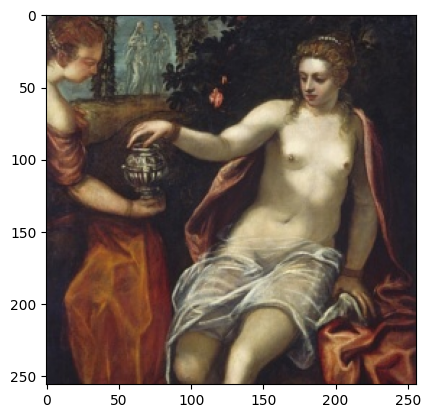

In [17]:
print(classes[labels[0]])
show_tensor_image(images)

['renaissance' 'post_impressionism' 'impressionism' 'baroque'
 'renaissance' 'ukiyo_e' 'ukiyo_e' 'romanticism' 'post_impressionism'
 'renaissance' 'art_nouveau' 'art_nouveau' 'impressionism' 'renaissance'
 'post_impressionism' 'post_impressionism' 'post_impressionism'
 'surrealism' 'post_impressionism' 'ukiyo_e' 'renaissance' 'baroque'
 'art_nouveau' 'impressionism' 'art_nouveau' 'renaissance' 'renaissance'
 'realism' 'surrealism' 'realism' 'renaissance' 'ukiyo_e']
torch.Size([32, 3, 256, 256])


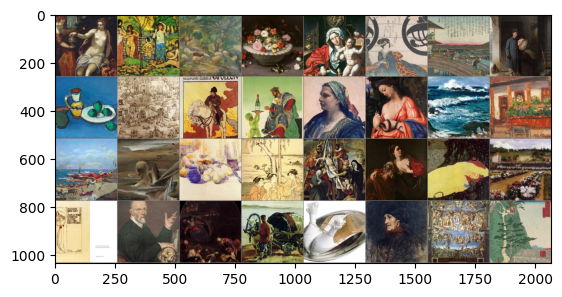

In [18]:
print(classes[labels])
show_tensor_image_batch(images)
print(images.shape)

In [19]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


# part 0: just playing around with stuff

In [20]:
# more packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [21]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [22]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [23]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [24]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [25]:
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [26]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        # self.mean = torch.tensor(mean).view(-1, 1, 1)
        # self.std = torch.tensor(std).view(-1, 1, 1)
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [27]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

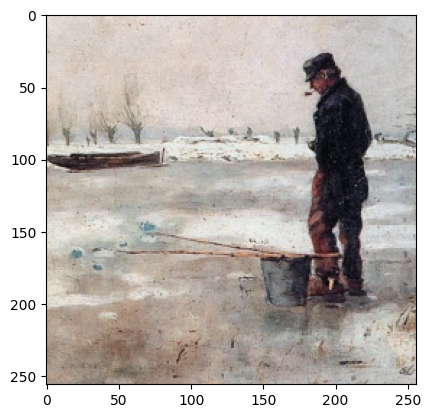

In [28]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]
show_tensor_image(image)

In [29]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [30]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                print(sl.loss)
                style_score += sl.loss
            for cl in content_losses:
                print(cl.loss)
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

In [31]:
transform = transforms.ToPILImage()

['impressionism' 'renaissance' 'art_nouveau' 'art_nouveau' 'realism'
 'post_impressionism' 'romanticism' 'renaissance' 'ukiyo_e' 'ukiyo_e'
 'ukiyo_e' 'realism' 'post_impressionism' 'ukiyo_e' 'surrealism'
 'art_nouveau' 'realism' 'realism' 'expressionism' 'expressionism'
 'renaissance' 'realism' 'expressionism' 'ukiyo_e' 'impressionism'
 'renaissance' 'impressionism' 'renaissance' 'baroque' 'realism'
 'post_impressionism' 'art_nouveau']


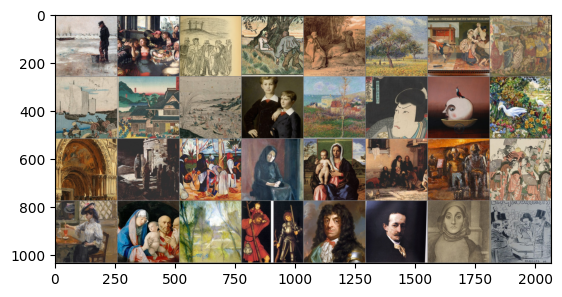

In [32]:
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
print(classes[labels])
show_tensor_image_batch(images)

content_img = images[:1]
style_img = images[3:]
input_img = images[:1]

In [33]:
# output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
#                             content_img, style_img, input_img)

# # plt.figure()
# # imshow(output, title='Output Image')

# # sphinx_gallery_thumbnail_number = 4
# # plt.ioff()
# # plt.show()

In [34]:
# show_tensor_image(output)

# part 1: playing around with adaIn

In [35]:
# style image
img_dir = "/content/drive/MyDrive/6.7900 Final Project/imgs"
os.chdir(img_dir)
!ls

alpha0.jpg    alpha25.jpg  alpha75.jpg		   surrealism-test.jpg
alpha100.jpg  alpha50.jpg  impressionism-test.jpg


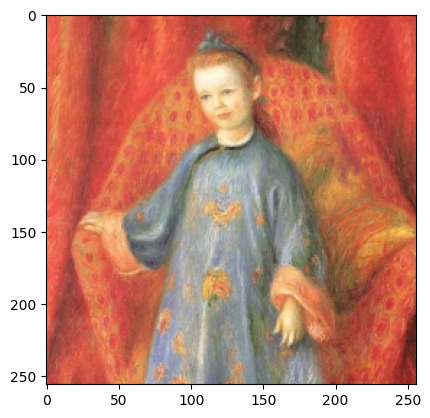

In [36]:
img_content = Image.open("impressionism-test.jpg")
img_style = Image.open("surrealism-test.jpg")
img_content = test_transform(img_content)
img_style = test_transform(img_style)

# show content image
show_tensor_image(img_content)

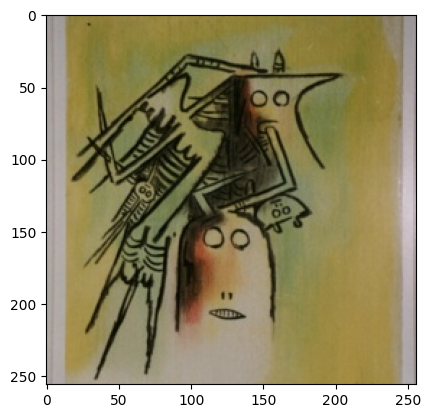

In [37]:
show_tensor_image(img_style)

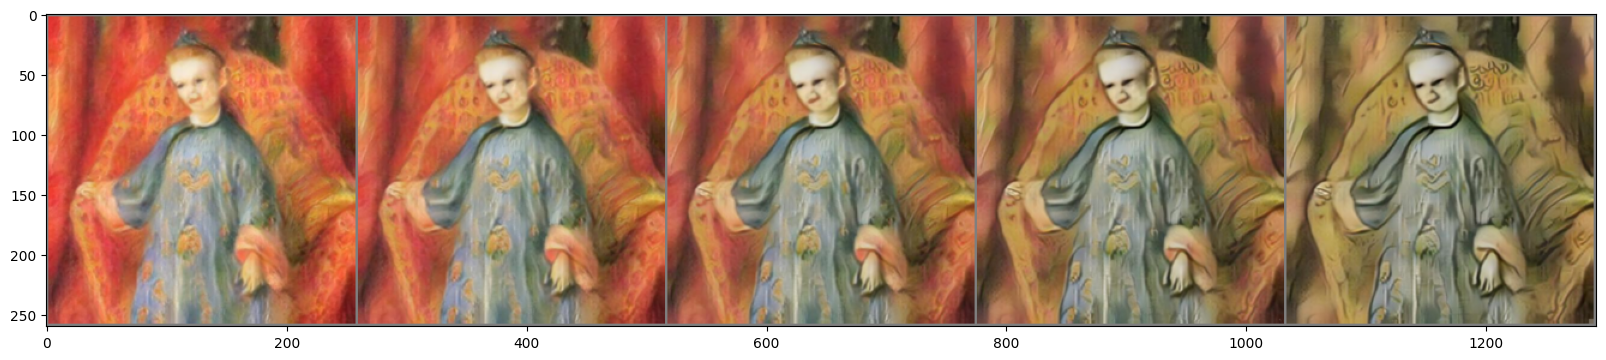

In [38]:
img_paths = ['alpha0.jpg', 'alpha25.jpg', 'alpha50.jpg', 'alpha75.jpg', 'alpha100.jpg']

batch = []

for path in img_paths:
  img_ai = Image.open(path)
  img_ai = test_transform(img_ai)
  batch.append(img_ai)

plt.figure(figsize=(20,20))
batch = torch.stack(batch)
show_tensor_image_batch(batch)

# part 2: fine tune VGG

In [39]:
vgg = vgg19(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [41]:
cwd = "/content/drive/MyDrive/6.7900 Final Project"
os.chdir(cwd)

In [42]:
train_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)
])
test_transform_vgg = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(cnn_normalization_mean, cnn_normalization_std)
])

In [43]:
classes

array(['art_nouveau', 'baroque', 'expressionism', 'impressionism',
       'post_impressionism', 'realism', 'renaissance', 'romanticism',
       'surrealism', 'ukiyo_e'], dtype='<U18')

In [44]:
labels = [8,9]
train_indices = [idx for idx, target in enumerate(train_dataset.targets) if target in labels]
test_indices = [idx for idx, target in enumerate(test_dataset.targets) if target in labels]
# data loaders
DATASET = dataset_path
# training dataset
vgg_train_dataset = datasets.ImageFolder(
    root=f'{DATASET}/train',
    transform=train_transform_vgg
)
# test dataset
vgg_test_dataset = datasets.ImageFolder(
    root=f'{DATASET}/test',
    transform=test_transform_vgg
)
vgg_train_loader = DataLoader(
    Subset(vgg_train_dataset, train_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
vgg_test_loader = DataLoader(
    Subset(vgg_test_dataset, test_indices), batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
)
# vgg_train_loader = DataLoader(
#     vgg_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
# )
# vgg_test_loader = DataLoader(
#     vgg_test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS
# )

In [45]:
dataiter = iter(vgg_test_loader)
images, labels = next(dataiter)

['surrealism' 'surrealism' 'ukiyo_e' 'ukiyo_e' 'ukiyo_e' 'ukiyo_e'
 'surrealism' 'ukiyo_e' 'surrealism' 'surrealism' 'ukiyo_e' 'ukiyo_e'
 'ukiyo_e' 'surrealism' 'ukiyo_e' 'ukiyo_e' 'ukiyo_e' 'ukiyo_e' 'ukiyo_e'
 'ukiyo_e' 'ukiyo_e' 'ukiyo_e' 'surrealism' 'ukiyo_e' 'ukiyo_e'
 'surrealism' 'ukiyo_e' 'ukiyo_e' 'surrealism' 'surrealism' 'ukiyo_e'
 'ukiyo_e']


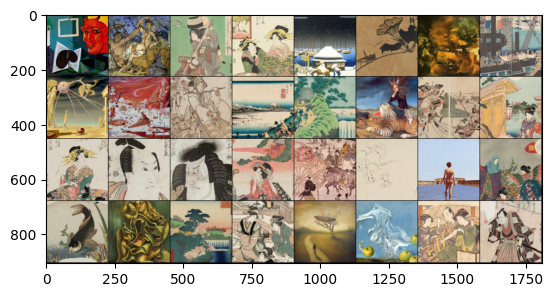

In [46]:
print(classes[labels])
show_tensor_image_batch_vgg(images)

In [47]:
# # freeze layers
# for param in vgg.parameters():
#     param.requires_grad_(False)

# # turn the last layer into a classifier
num_classes = 10
vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=num_classes)
vgg = vgg.to(device)

In [48]:
# CHANGE according to whatever labels you have
def map_labels(labels):
  return torch.tensor([0 if label == 8 else 1 for label in labels]).to(device)

criterion = nn.CrossEntropyLoss().to(device)
def evaluate(model, loader):
  correct = 0
  total = 0
  total_loss = 0.0
  iters = 0
  total_classes = [0 for i in range(10)]
  correct_classes = [0 for i in range(10)]
  with torch.no_grad():
    for inputs, labels in tqdm(loader, desc="Testing", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = map_labels(labels)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()
        iters += 1

        # for i, label in enumerate(labels):
        #   if (label == predicted[i]):
        #     correct_classes[label]+=1
        #   total_classes[label]+=1

  accuracy = correct / total
  print(f'Test Accuracy: {accuracy * 100:.2f}%')
  # print(correct_classes)
  # print(total_classes)
  # print(np.array(correct_classes)/np.array(total_classes))
  return correct, total, total_loss / iters

In [49]:
vgg = vgg.to(device)
correct, total, loss = evaluate(vgg, vgg_test_loader)
# correct, total, loss = evaluate(vgg, vgg_test_loader)

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 5.65%


In [50]:
from torchsummary import summary
summary(vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [51]:
def check_trainable(model):
  layer_requires_grad = []
  for param in model.parameters():
    layer_requires_grad.append(param.requires_grad)
  for i,layer in enumerate(model.features.eval()):
    print(layer, layer_requires_grad[i])

In [52]:
# make the last block trainable
for i, param in enumerate(vgg.parameters()):
    param.requires_grad = True
check_trainable(vgg)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) True
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) True
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
ReLU(inplace=True) True
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [53]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model, layers):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*original_model.features.children())
        self.save_layers = layers

    def forward(self, x):
      out = []
      for i, layer in enumerate(self.features):
        x = layer(x)
        if i+1 in self.save_layers:
          flattened_feature = x.view(x.size(0), -1)
          out.append(flattened_feature)
      return out

class LinearClassifier(nn.Module):
    def __init__(self, original_model, in_features, num_classes):
        super(LinearClassifier, self).__init__()
        self.classifier = original_model.classifier
        self.classifier[-1] = nn.Linear(in_features=self.classifier[-1].in_features, out_features=num_classes)
        self.classifier[0] = nn.Linear(in_features=in_features, out_features = self.classifier[0].out_features)

    def forward(self, x):
        x = self.classifier(x)
        return x

In [54]:
# vgg_feature_extractor = FeatureExtractor(vgg, [5, 10, 19, 28, 37])
# linear_classifier_1 = LinearClassifier(vgg, 802816, 2)
# linear_classifier_2 = LinearClassifier(vgg, 401408, 2)
# linear_classifier_3 = LinearClassifier(vgg, 200704, 2)
# linear_classifier_4 = LinearClassifier(vgg, 100352, 2)
# linear_classifier_5 = LinearClassifier(vgg, 25088, 2)

In [91]:
import torch.optim as optim
import time


def train(model, trainloader, testloader, num_epochs, save_path, save_loss_path, save_accuracy_path, save_loss_test_path, save_accuracy_test_path):
  model = model.train()
  model = model.to(device)

  # Loss function and optimizer
  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.001)

  loss_list = []
  accuracy_list = []
  loss_test_list = []
  accuracy_test_list = []
  # Training loop
  for epoch in tqdm(range(num_epochs), total=num_epochs):  # Loop over the dataset multiple times
      running_loss = 0.0
      correct = 0
      total = 0

      total_running_loss = 0.0
      total_correct = 0
      total_total = 0
      num_iters = 0
      start_time = time.time()

      for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
          # Get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(device), data[1].to(device)
          labels = map_labels(labels)

          # Zero the parameter gradients
          optimizer.zero_grad()

          inputs = inputs.to(device)
          labels = labels.to(device)
          # Forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # Update statistics
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          total_total += labels.size(0)
          correct += (predicted == labels).sum().item()
          total_correct += (predicted == labels).sum().item()
          num_iters += 1
          total_running_loss += loss.item()

          # Print detailed statistics
          if i % 50 == 0:
              current_lr = optimizer.param_groups[0]['lr']
              print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(trainloader)}], '
                    f'Loss: {running_loss / 50:.3f}, '
                    f'Accuracy: {100 * correct / total:.2f}%, '
                    f'LR: {current_lr}')
              running_loss = 0.0
              correct = 0
              total = 0

              loss_list.append(total_running_loss / num_iters)
              accuracy_list.append(total_correct / total_total)
              test_correct, test_total, test_loss = evaluate(model, testloader)
              print("test correct, test total, test accuracy, test loss:", test_correct, test_total, test_correct / test_total, test_loss)
              loss_test_list.append(test_loss)
              accuracy_test_list.append(test_correct / test_total)

      # Save the model
      print("end of epoch: saving model metadata...")
      torch.save(model.state_dict(), save_path)
      torch.save(loss_list, save_loss_path)
      torch.save(accuracy_list, save_accuracy_path)
      torch.save(loss_test_list, save_loss_test_path)
      torch.save(accuracy_test_list, save_accuracy_test_path)

      epoch_duration = time.time() - start_time
      print(f'End of Epoch {epoch + 1}, Duration: {epoch_duration:.2f} seconds')

  print('Finished Training')


In [56]:
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# transform_mnist = transforms.Compose([
#     transforms.ToTensor(),  # Convert images to PyTorch tensors
#     transforms.Lambda(lambda x: torch.nn.functional.interpolate(x.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)),  # Resize to 224x224
#     transforms.Normalize(0.456, 0.224)  # Normalize the pixel values to be in the range [-1, 1]
# ])

# mnist_train_dataset = datasets.MNIST(root='./data', train=True, transform=transform_mnist, download=True)

# # Create a DataLoader for the training dataset
# mnist_train_loader = DataLoader(dataset=mnist_train_dataset, batch_size=64, shuffle=True, num_workers=2)

In [57]:
# images, labels = next(iter(mnist_train_loader))
# print(labels)
# show_tensor_image_batch(images)

In [92]:
# vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
vgg = vgg19(pretrained=True)
# CHANGE based on number of out_features
vgg.classifier[-1] = nn.Linear(in_features=vgg.classifier[-1].in_features, out_features=2)
vgg = vgg.to(device)

In [93]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [94]:
# save_path = "mnist_vgg_model.pt"
# save_loss_path = "mnist_vgg_model_loss"
# save_accuracy_path = "mnist_vgg_model_accuracy"

# save_path = "vgg_model_10.pt"
# save_loss_path = "vgg_model_loss_10"
# save_loss_test_path = "vgg_model_test_loss_10"
# save_accuracy_path = "vgg_model_accuracy_10"
# save_accuracy_test_path = "vgg_model_accuracy_test_10"

save_path = "vgg_model.pt"
save_loss_path = "vgg_model_loss"
save_loss_test_path = "vgg_model_test_loss"
save_accuracy_path = "vgg_model_accuracy"
save_accuracy_test_path = "vgg_model_accuracy_test"

In [95]:
train(vgg.to(device), vgg_train_loader, vgg_test_loader, 50, save_path, save_loss_path, save_accuracy_path, save_loss_test_path, save_accuracy_test_path)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/50], Step [1/313], Loss: 0.015, Accuracy: 53.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 57.20%
test correct, test total, test accuracy, test loss: 1144 2000 0.572 0.6894422816851783
Epoch [1/50], Step [51/313], Loss: 0.433, Accuracy: 82.25%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 90.00%
test correct, test total, test accuracy, test loss: 1800 2000 0.9 0.27262405105053433
Epoch [1/50], Step [101/313], Loss: 0.207, Accuracy: 92.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 94.20%
test correct, test total, test accuracy, test loss: 1884 2000 0.942 0.16507215650072174
Epoch [1/50], Step [151/313], Loss: 0.164, Accuracy: 94.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 95.25%
test correct, test total, test accuracy, test loss: 1905 2000 0.9525 0.12964782393759205
Epoch [1/50], Step [201/313], Loss: 0.109, Accuracy: 96.44%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 95.85%
test correct, test total, test accuracy, test loss: 1917 2000 0.9585 0.10753329893544553
Epoch [1/50], Step [251/313], Loss: 0.102, Accuracy: 96.06%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.75%
test correct, test total, test accuracy, test loss: 1935 2000 0.9675 0.10310090474400019
Epoch [1/50], Step [301/313], Loss: 0.077, Accuracy: 97.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.40%
test correct, test total, test accuracy, test loss: 1928 2000 0.964 0.09140268356968013
end of epoch: saving model metadata...
End of Epoch 1, Duration: 297.91 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/50], Step [1/313], Loss: 0.007, Accuracy: 90.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.15%
test correct, test total, test accuracy, test loss: 1923 2000 0.9615 0.0914064415301832
Epoch [2/50], Step [51/313], Loss: 0.080, Accuracy: 97.50%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.60%
test correct, test total, test accuracy, test loss: 1932 2000 0.966 0.08744913129697716
Epoch [2/50], Step [101/313], Loss: 0.060, Accuracy: 97.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.75%
test correct, test total, test accuracy, test loss: 1935 2000 0.9675 0.09122775786275429
Epoch [2/50], Step [151/313], Loss: 0.056, Accuracy: 98.19%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.20%
test correct, test total, test accuracy, test loss: 1944 2000 0.972 0.07539965642527455
Epoch [2/50], Step [201/313], Loss: 0.077, Accuracy: 97.19%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.70%
test correct, test total, test accuracy, test loss: 1954 2000 0.977 0.06802535969911823
Epoch [2/50], Step [251/313], Loss: 0.062, Accuracy: 98.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.20%
test correct, test total, test accuracy, test loss: 1944 2000 0.972 0.07409534985495228
Epoch [2/50], Step [301/313], Loss: 0.059, Accuracy: 97.38%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.65%
test correct, test total, test accuracy, test loss: 1953 2000 0.9765 0.06793101650795766
end of epoch: saving model metadata...
End of Epoch 2, Duration: 267.54 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Testing:   0%|          | 0/63 [00:40<?, ?it/s]

Epoch [3/50], Step [1/313], Loss: 0.002, Accuracy: 96.88%, LR: 0.001
Test Accuracy: 97.60%
test correct, test total, test accuracy, test loss: 1952 2000 0.976 0.0644555641301272
Epoch [3/50], Step [51/313], Loss: 0.046, Accuracy: 97.81%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.70%
test correct, test total, test accuracy, test loss: 1954 2000 0.977 0.06410333232968927
Epoch [3/50], Step [101/313], Loss: 0.045, Accuracy: 98.31%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.65%
test correct, test total, test accuracy, test loss: 1953 2000 0.9765 0.06620594992538885
Epoch [3/50], Step [151/313], Loss: 0.059, Accuracy: 97.88%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.50%
test correct, test total, test accuracy, test loss: 1950 2000 0.975 0.05926731728490383
Epoch [3/50], Step [201/313], Loss: 0.037, Accuracy: 98.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.85%
test correct, test total, test accuracy, test loss: 1957 2000 0.9785 0.05820628730875869
Epoch [3/50], Step [251/313], Loss: 0.035, Accuracy: 98.94%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.85%
test correct, test total, test accuracy, test loss: 1957 2000 0.9785 0.05737932534178808
Epoch [3/50], Step [301/313], Loss: 0.038, Accuracy: 98.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.95%
test correct, test total, test accuracy, test loss: 1959 2000 0.9795 0.06253581535115484
end of epoch: saving model metadata...
End of Epoch 3, Duration: 367.55 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [4/50], Step [1/313], Loss: 0.000, Accuracy: 100.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.95%
test correct, test total, test accuracy, test loss: 1959 2000 0.9795 0.057542537592188824
Epoch [4/50], Step [51/313], Loss: 0.026, Accuracy: 99.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.80%
test correct, test total, test accuracy, test loss: 1956 2000 0.978 0.060014527028663056
Epoch [4/50], Step [101/313], Loss: 0.042, Accuracy: 98.44%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.90%
test correct, test total, test accuracy, test loss: 1958 2000 0.979 0.06869909103723272
Epoch [4/50], Step [151/313], Loss: 0.042, Accuracy: 98.56%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.95%
test correct, test total, test accuracy, test loss: 1939 2000 0.9695 0.07824957564783593
Epoch [4/50], Step [201/313], Loss: 0.031, Accuracy: 98.75%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.90%
test correct, test total, test accuracy, test loss: 1958 2000 0.979 0.059497470767902474
Epoch [4/50], Step [251/313], Loss: 0.035, Accuracy: 99.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.05%
test correct, test total, test accuracy, test loss: 1961 2000 0.9805 0.05224033280475331
Epoch [4/50], Step [301/313], Loss: 0.028, Accuracy: 99.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.20%
test correct, test total, test accuracy, test loss: 1964 2000 0.982 0.05509417104564371
end of epoch: saving model metadata...
End of Epoch 4, Duration: 367.78 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [5/50], Step [1/313], Loss: 0.001, Accuracy: 100.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.80%
test correct, test total, test accuracy, test loss: 1956 2000 0.978 0.05895370279350096
Epoch [5/50], Step [51/313], Loss: 0.019, Accuracy: 99.06%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.05%
test correct, test total, test accuracy, test loss: 1961 2000 0.9805 0.05993226035923091
Epoch [5/50], Step [101/313], Loss: 0.017, Accuracy: 99.50%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.10%
test correct, test total, test accuracy, test loss: 1962 2000 0.981 0.057848489944017416
Epoch [5/50], Step [151/313], Loss: 0.034, Accuracy: 98.75%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.10%
test correct, test total, test accuracy, test loss: 1962 2000 0.981 0.053122933037460796
Epoch [5/50], Step [201/313], Loss: 0.023, Accuracy: 99.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.55%
test correct, test total, test accuracy, test loss: 1971 2000 0.9855 0.043246377892385696
Epoch [5/50], Step [251/313], Loss: 0.036, Accuracy: 98.75%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.30%
test correct, test total, test accuracy, test loss: 1966 2000 0.983 0.051385511154501094
Epoch [5/50], Step [301/313], Loss: 0.029, Accuracy: 99.06%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.20%
test correct, test total, test accuracy, test loss: 1964 2000 0.982 0.05185086214046423
end of epoch: saving model metadata...
End of Epoch 5, Duration: 267.90 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [6/50], Step [1/313], Loss: 0.000, Accuracy: 100.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.20%
test correct, test total, test accuracy, test loss: 1964 2000 0.982 0.05203907534901407
Epoch [6/50], Step [51/313], Loss: 0.021, Accuracy: 99.25%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.35%
test correct, test total, test accuracy, test loss: 1967 2000 0.9835 0.04659340344092232
Epoch [6/50], Step [101/313], Loss: 0.019, Accuracy: 99.38%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.20%
test correct, test total, test accuracy, test loss: 1964 2000 0.982 0.05644515341809315
Epoch [6/50], Step [151/313], Loss: 0.025, Accuracy: 99.25%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.40%
test correct, test total, test accuracy, test loss: 1968 2000 0.984 0.05271818893056156
Epoch [6/50], Step [201/313], Loss: 0.019, Accuracy: 99.50%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.45%
test correct, test total, test accuracy, test loss: 1969 2000 0.9845 0.045598510006952676
Epoch [6/50], Step [251/313], Loss: 0.027, Accuracy: 98.75%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.55%
test correct, test total, test accuracy, test loss: 1971 2000 0.9855 0.04415378668936827
Epoch [6/50], Step [301/313], Loss: 0.030, Accuracy: 98.81%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.60%
test correct, test total, test accuracy, test loss: 1972 2000 0.986 0.04540277710036626
end of epoch: saving model metadata...
End of Epoch 6, Duration: 358.27 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [7/50], Step [1/313], Loss: 0.001, Accuracy: 96.88%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.45%
test correct, test total, test accuracy, test loss: 1969 2000 0.9845 0.04985164662006326
Epoch [7/50], Step [51/313], Loss: 0.021, Accuracy: 99.25%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.60%
test correct, test total, test accuracy, test loss: 1972 2000 0.986 0.046375156801548745
Epoch [7/50], Step [101/313], Loss: 0.022, Accuracy: 98.81%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.70%
test correct, test total, test accuracy, test loss: 1974 2000 0.987 0.03723088134309307
Epoch [7/50], Step [151/313], Loss: 0.011, Accuracy: 99.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.35%
test correct, test total, test accuracy, test loss: 1967 2000 0.9835 0.04782481652884079
Epoch [7/50], Step [201/313], Loss: 0.016, Accuracy: 99.31%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.40%
test correct, test total, test accuracy, test loss: 1968 2000 0.984 0.042759977299110255
Epoch [7/50], Step [251/313], Loss: 0.021, Accuracy: 99.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.05%
test correct, test total, test accuracy, test loss: 1961 2000 0.9805 0.06149990289815746
Epoch [7/50], Step [301/313], Loss: 0.020, Accuracy: 99.38%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.60%
test correct, test total, test accuracy, test loss: 1972 2000 0.986 0.046243824444698274
end of epoch: saving model metadata...
End of Epoch 7, Duration: 367.74 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [8/50], Step [1/313], Loss: 0.001, Accuracy: 96.88%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.35%
test correct, test total, test accuracy, test loss: 1967 2000 0.9835 0.040952652252079655
Epoch [8/50], Step [51/313], Loss: 0.016, Accuracy: 99.31%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.10%
test correct, test total, test accuracy, test loss: 1962 2000 0.981 0.04837017481518809
Epoch [8/50], Step [101/313], Loss: 0.021, Accuracy: 99.25%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.60%
test correct, test total, test accuracy, test loss: 1972 2000 0.986 0.044402964168786266
Epoch [8/50], Step [151/313], Loss: 0.013, Accuracy: 99.38%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.50%
test correct, test total, test accuracy, test loss: 1970 2000 0.985 0.04144144975875933
Epoch [8/50], Step [201/313], Loss: 0.018, Accuracy: 99.44%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.70%
test correct, test total, test accuracy, test loss: 1974 2000 0.987 0.037264089152033976
Epoch [8/50], Step [251/313], Loss: 0.010, Accuracy: 99.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.55%
test correct, test total, test accuracy, test loss: 1971 2000 0.9855 0.04405079495867655
Epoch [8/50], Step [301/313], Loss: 0.017, Accuracy: 99.19%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.15%
test correct, test total, test accuracy, test loss: 1963 2000 0.9815 0.04462796535840931
end of epoch: saving model metadata...
End of Epoch 8, Duration: 267.65 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [9/50], Step [1/313], Loss: 0.000, Accuracy: 100.00%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.25%
test correct, test total, test accuracy, test loss: 1965 2000 0.9825 0.0487888429140892
Epoch [9/50], Step [51/313], Loss: 0.020, Accuracy: 98.94%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.50%
test correct, test total, test accuracy, test loss: 1970 2000 0.985 0.04922818611105738
Epoch [9/50], Step [101/313], Loss: 0.013, Accuracy: 99.44%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 98.60%
test correct, test total, test accuracy, test loss: 1972 2000 0.986 0.044985662825291955
Epoch [9/50], Step [151/313], Loss: 0.011, Accuracy: 99.62%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd04986fe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd04986fe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test Accuracy: 98.85%
test correct, test total, test accuracy, test loss: 1977 2000 0.9885 0.050331526202388066


KeyboardInterrupt: ignored

## run same binary classification task with resnet

In [78]:
from torchvision import models
resnet = models.resnet50(pretrained=True)

# Modify the final fully connected layer for 10 output classes
resnet.fc = nn.Linear(resnet.fc.in_features, 2)

In [79]:
resnet_save_path = "resnet_model.pt"
resnet_save_loss_path = "resnet_model_loss"
resnet_save_loss_test_path = "resnet_model_test_loss"
resnet_save_accuracy_path = "resnet_model_accuracy"
resnet_save_accuracy_test_path = "resnet_model_accuracy_test"

In [80]:
train(resnet.to(device), vgg_train_loader, vgg_test_loader, 50, resnet_save_path, resnet_save_loss_path, resnet_save_accuracy_path, resnet_save_loss_test_path, resnet_save_accuracy_test_path)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [1/50], Step [1/313], Loss: 0.014, Accuracy: 56.25%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 53.75%
test correct, test total, test accuracy, test loss: 1075 2000 0.5375 0.6857292746740674
Epoch [1/50], Step [51/313], Loss: 0.563, Accuracy: 79.94%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 91.60%
test correct, test total, test accuracy, test loss: 1832 2000 0.916 0.46253607150108095
Epoch [1/50], Step [101/313], Loss: 0.394, Accuracy: 93.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 94.35%
test correct, test total, test accuracy, test loss: 1887 2000 0.9435 0.3395330428131043
Epoch [1/50], Step [151/313], Loss: 0.299, Accuracy: 95.06%, LR: 0.001


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd04986fe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd04986fe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Testing:   0%|          | 0/63 [00:00<?, ?it/s]

can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd04986fe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd04986fe20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w

Test Accuracy: 94.60%
test correct, test total, test accuracy, test loss: 1892 2000 0.946 0.2710238058888723
Epoch [1/50], Step [201/313], Loss: 0.239, Accuracy: 95.44%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.15%
test correct, test total, test accuracy, test loss: 1923 2000 0.9615 0.2173999391850971
Epoch [1/50], Step [251/313], Loss: 0.205, Accuracy: 95.75%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.65%
test correct, test total, test accuracy, test loss: 1933 2000 0.9665 0.1809095557010363
Epoch [1/50], Step [301/313], Loss: 0.173, Accuracy: 96.31%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.80%
test correct, test total, test accuracy, test loss: 1936 2000 0.968 0.15383004385327537
end of epoch: saving model metadata...
End of Epoch 1, Duration: 1400.87 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [2/50], Step [1/313], Loss: 0.004, Accuracy: 96.88%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.55%
test correct, test total, test accuracy, test loss: 1931 2000 0.9655 0.15335199118606627
Epoch [2/50], Step [51/313], Loss: 0.143, Accuracy: 96.31%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.60%
test correct, test total, test accuracy, test loss: 1932 2000 0.966 0.14171768500218315
Epoch [2/50], Step [101/313], Loss: 0.119, Accuracy: 97.50%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.65%
test correct, test total, test accuracy, test loss: 1933 2000 0.9665 0.13102854563603325
Epoch [2/50], Step [151/313], Loss: 0.112, Accuracy: 98.12%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.65%
test correct, test total, test accuracy, test loss: 1933 2000 0.9665 0.1179343843980441
Epoch [2/50], Step [201/313], Loss: 0.098, Accuracy: 98.06%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 96.95%
test correct, test total, test accuracy, test loss: 1939 2000 0.9695 0.10748657513232458
Epoch [2/50], Step [251/313], Loss: 0.096, Accuracy: 97.69%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.30%
test correct, test total, test accuracy, test loss: 1946 2000 0.973 0.09798081378851618
Epoch [2/50], Step [301/313], Loss: 0.097, Accuracy: 97.31%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.15%
test correct, test total, test accuracy, test loss: 1943 2000 0.9715 0.0951079758150237
end of epoch: saving model metadata...
End of Epoch 2, Duration: 214.83 seconds


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch [3/50], Step [1/313], Loss: 0.002, Accuracy: 96.88%, LR: 0.001


Testing:   0%|          | 0/63 [00:00<?, ?it/s]

Test Accuracy: 97.40%
test correct, test total, test accuracy, test loss: 1948 2000 0.974 0.08913734401502306


KeyboardInterrupt: ignored

In [82]:
loss_list = torch.load(resnet_save_loss_path)
accuracy_list = torch.load(resnet_save_accuracy_path)
loss_test_list = torch.load(resnet_save_loss_test_path)
accuracy_test_list = torch.load(resnet_save_accuracy_test_path)

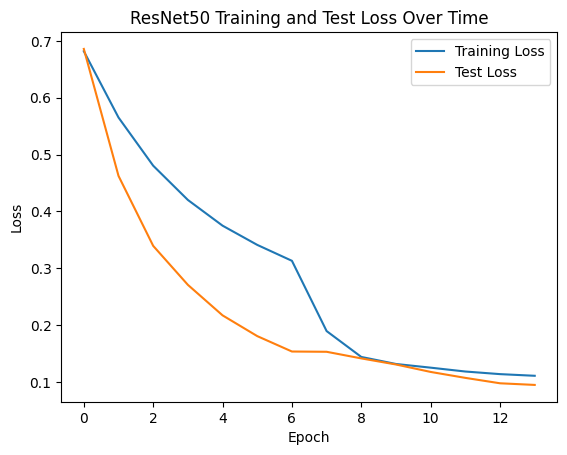

In [85]:
plt.plot(loss_list, label='Training Loss')
plt.plot(loss_test_list, label='Test Loss')

# Adding titles and labels
plt.title('ResNet50 Training and Test Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

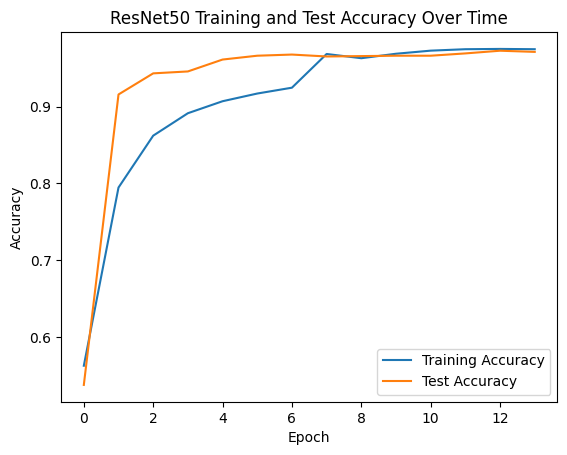

In [86]:
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(accuracy_test_list, label='Test Accuracy')

# Adding titles and labels
plt.title('ResNet50 Training and Test Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

# set up PCA

In [96]:
model = torch.load(save_path)
loss_list = torch.load(save_loss_path)
accuracy_list = torch.load(save_accuracy_path)
loss_test_list = torch.load(save_loss_test_path)
accuracy_test_list = torch.load(save_accuracy_test_path)
vgg.load_state_dict(model)
vgg = vgg.eval()

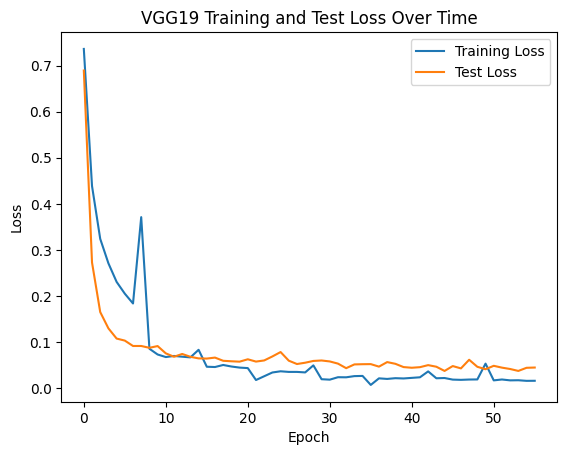

In [97]:
plt.plot(loss_list, label='Training Loss')
plt.plot(loss_test_list, label='Test Loss')

# Adding titles and labels
plt.title('VGG19 Training and Test Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

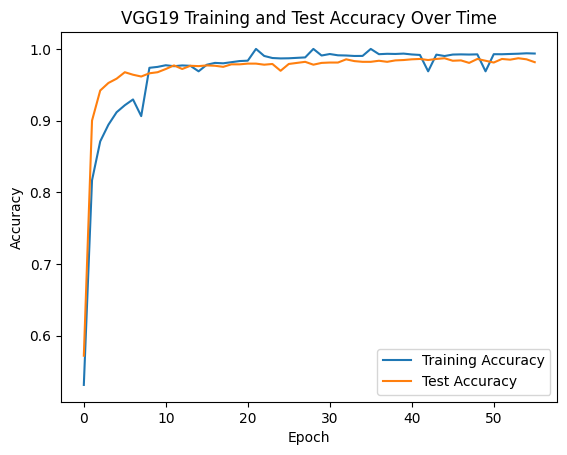

In [98]:
plt.plot(accuracy_list, label='Training Accuracy')
plt.plot(accuracy_test_list, label='Test Accuracy')

# Adding titles and labels
plt.title('VGG19 Training and Test Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [ ]:
vgg_feature_extractor = FeatureExtractor(vgg, [5, 10, 19, 28, 37])
vgg_feature_extractor.eval()

In [ ]:
# labels = [2, 3]
# indices = [idx for idx, target in enumerate(mnist_train_dataset.targets) if target in labels]
# mnist_train_dataloader_23 = torch.utils.data.DataLoader(Subset(mnist_train_dataset, indices),
#                                          batch_size=64)
dataloader = vgg_test_loader

In [ ]:
get_batches = 2

features = []
labels = []

with torch.no_grad():
  images = []
  labels = []
  for i in range(get_batches):
      images_i, labels_i = next(iter(dataloader))
      images.append(images_i)
      labels.append(labels_i)

  images = torch.cat(images, dim=0)
  labels = torch.cat(labels, dim=0)
  print(images.shape)
  features = vgg_feature_extractor(images.to(device))

labels = map_labels(labels).detach().cpu()
print(labels)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming you want to plot the first four layers
num_layers_to_plot = 5

# Get the class names
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# class_names = ['0', '1']
class_names = {0: 'surrealism', 1: 'ukiyo-e'}

# Set up a grid for subplots
fig, axes = plt.subplots(1, num_layers_to_plot, figsize=(20, 5))

pca_results = []

for i, ax in enumerate(axes.flatten()):
    if i < len(features):
        layer_features = features[i]
        # Ensure the data is more than one-dimensional
        if layer_features.ndim > 1 and layer_features.shape[1] > 1:
            # Standardize the data
            scaler = StandardScaler()
            X_standardized = scaler.fit_transform(layer_features.detach().cpu())

            # Apply PCA
            pca = PCA(n_components=2)
            pca_result = pca.fit_transform(X_standardized)

            pca_results.append(pca_result)

            # Scatter plot for this layer
            scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='none', alpha=0.7)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_title(f'PCA of Layer {i + 1}')

            # Create a legend with readable labels
            unique_labels = np.unique(labels)
            for unique_label in unique_labels:
                idx = labels == unique_label
                ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7)
            ax.legend()
        else:
            ax.set_visible(False)
    else:
        ax.set_visible(False)

# Show the plot
plt.show()

In [ ]:
# Assuming you want to plot the first four layers
num_layers_to_plot = 5
class_names = {0: 'surrealism', 1: 'ukiyo-e', 2: 'special'}

num_rows = 5

# Set up a grid for subplots
fig, axes = plt.subplots(num_rows, num_layers_to_plot, figsize=(20,20))

for i, ax in enumerate(axes.flatten()):
  index = i - (i // num_rows) * num_rows
  pca_result = pca_results[index]

  # Scatter plot for this layer
  scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', edgecolor='none', alpha=0.7)

  # Create a legend with readable labels
  labels[-1] = 2
  unique_labels = np.unique(labels)
  for unique_label in unique_labels:
      if (unique_label != 2):
        idx = labels == unique_label
        ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7)
      else:
        idx = labels == unique_label
        ax.scatter(pca_result[idx, 0], pca_result[idx, 1], label=class_names[unique_label.item()], alpha=0.7, color='r')
  ax.set_xticks([])
  ax.set_yticks([])
  ax.legend(fontsize='small')

# Show the plot
plt.show()

# load adaIN data and create trajectories